## Import Classes and Libraries

In [1]:
import DataLoader 
import preprocessor 
import Model 
import plot_data

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from itertools import chain, combinations
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Dataset

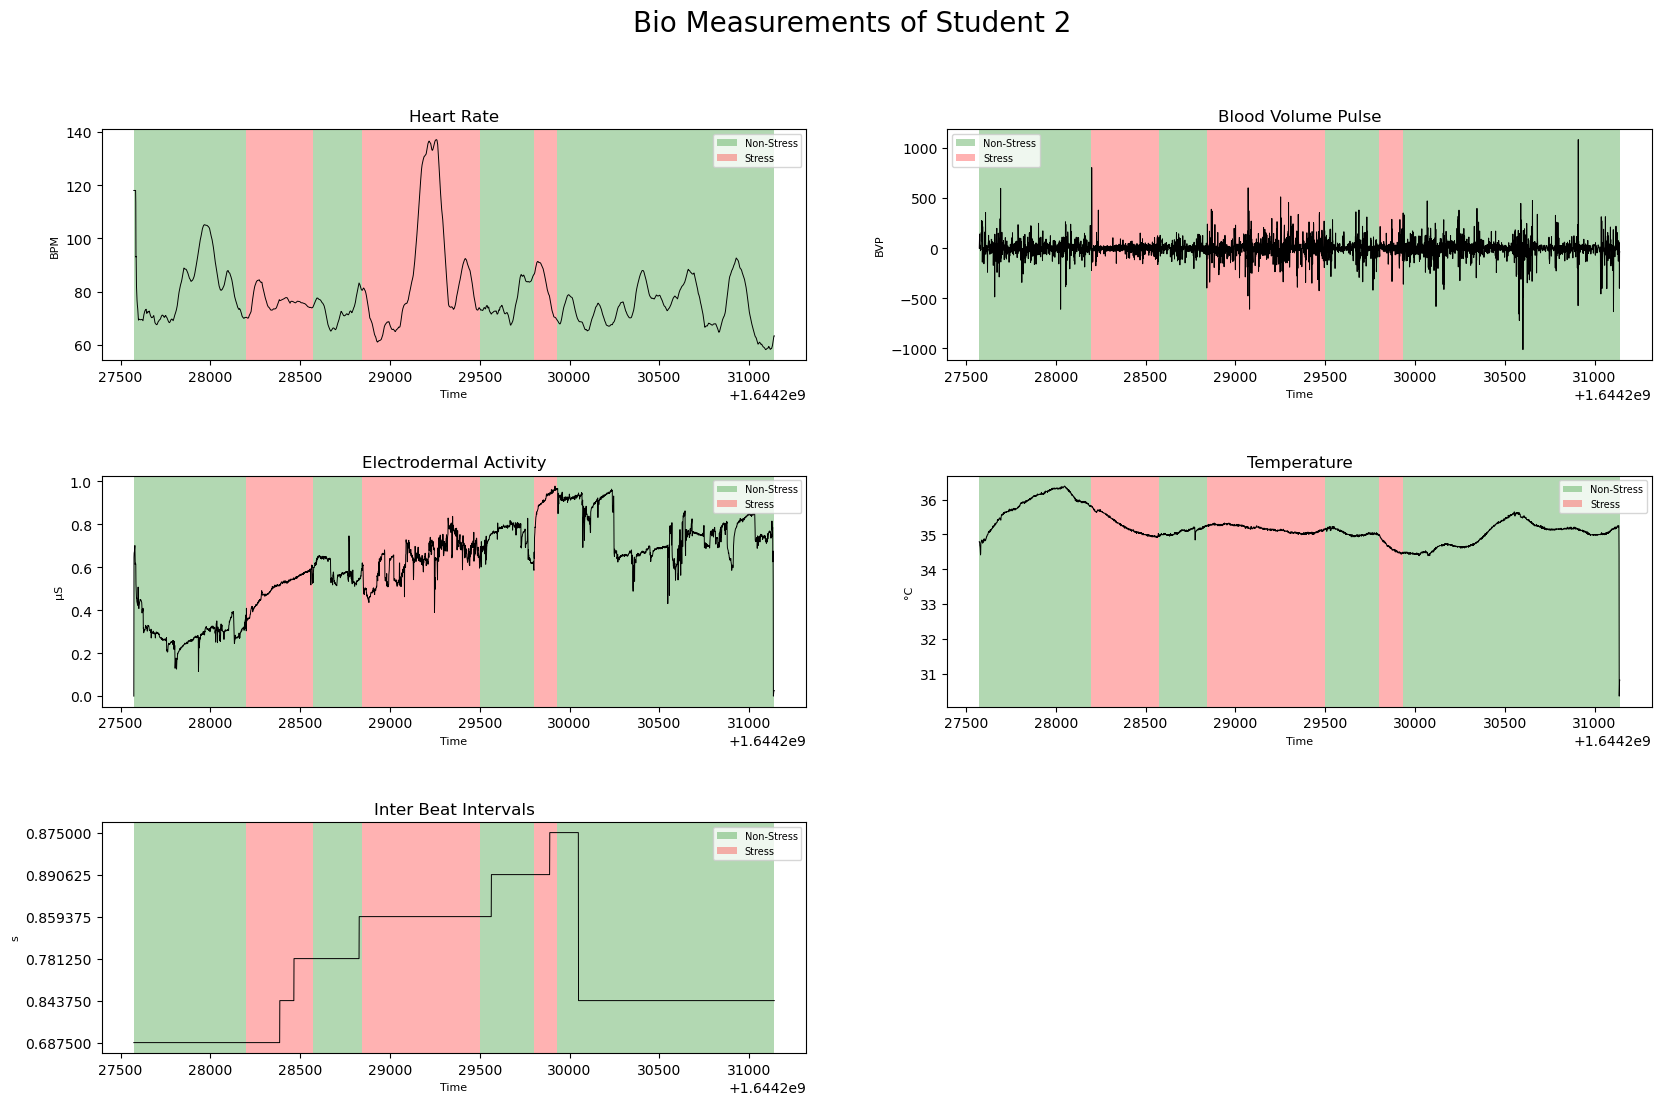

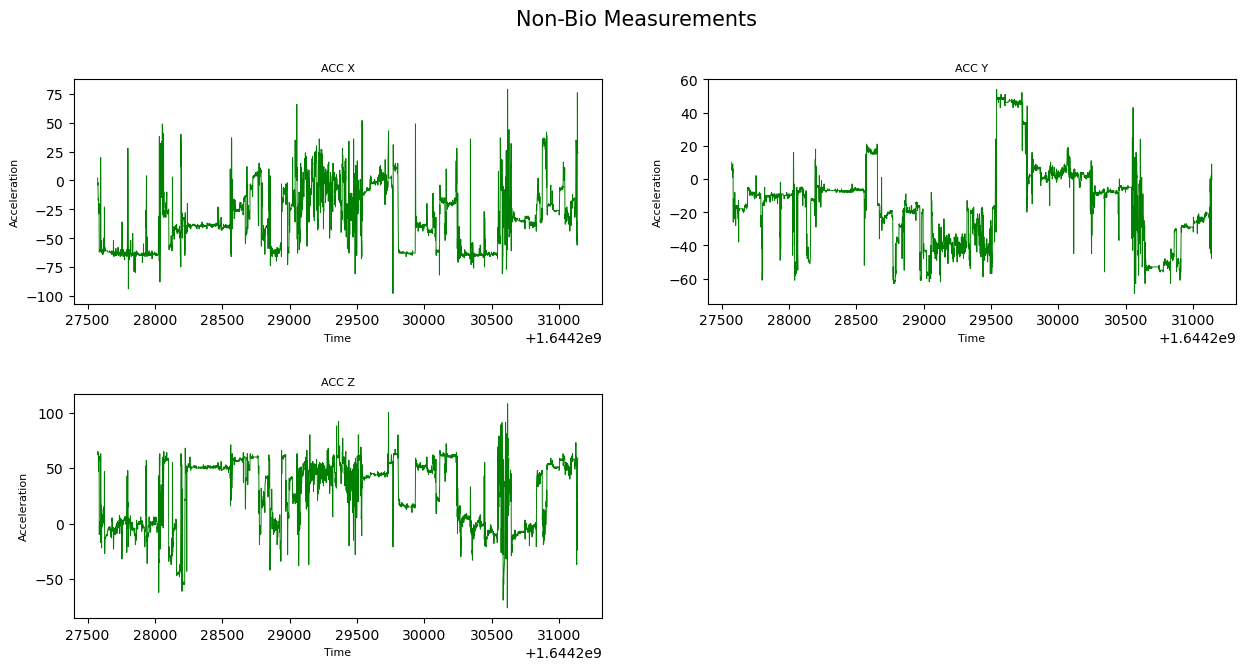

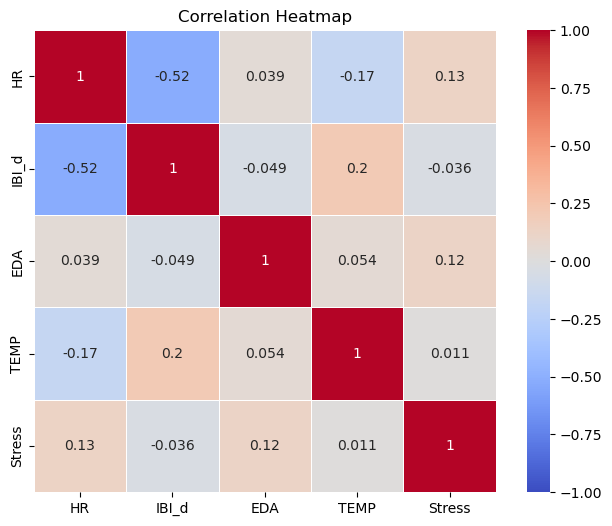

In [3]:
data = DataLoader.dataloader(path='Stress-Predict-Dataset-main/Raw_data/', save =False) # save = Ture means don't do whole the proccess. just load the proccessed csv file that was saved before 
dataset = data.load(fs=1) # fs = 1 means make the f of all the signals 1 Hz
tag = data.tags() # get all the tags 

plot_data.plot_bio_measurements(dataset,tags=tag, ID=2)
plot_data.plot_Non_Bio_Measurements(dataset, ID=2)

# polt heatmap of correlation 
d = dataset[['HR', 'IBI_d', 'EDA', 'TEMP', 'Stress']]
corr_matrix = d.corr(numeric_only=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

## Analysing Features

In [6]:
def get_combinations(input_list): # get the all combinations of items list without permutation
    result = list(chain.from_iterable(combinations(input_list, r) for r in range(1, len(input_list) + 1)))
    return [list(combination) for combination in result]
  
def expand_features(feature_lists):# takes a list of feature lists (feature_lists) as input and expands any feature names that have a mapping defined in the mapping dictionary.
    
    # Define a mapping dictionary for expanding features
    mapping = {
        'ACC': ['ACC_x', 'ACC_y', 'ACC_z']
    }
    expanded_lists = []
    # Iterate over each feature_list in the input feature_lists
    for feature_list in feature_lists:
        expanded_list = [mapping.get(feature, feature) for feature in feature_list]
        expanded_list = [item for sublist in expanded_list for item in (sublist if isinstance(sublist, list) else [sublist])]
        expanded_lists.append(expanded_list)
    return expanded_lists

In [7]:
Feature_list = ['ACC', 'BVP', 'HR', 'TEMP', 'EDA', 'IBI_d']
Feature_list = get_combinations(Feature_list)
expanded_lists = expand_features(Feature_list)

In [ ]:
def evaluation(y_val, y_pred): # Evaluate the model's performance by calculating the accuracy, F1 score.

    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    return [accuracy, f1]

# finding best window size and stride and best feature combination
results = []
for windows in [5, 10, 15, 20, 30]:
    for strides in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    proc = preprocessor.preprocessor(dataset)
    proc.make_time_serises(window_size=windows, stride=strides)
    train_data , test_data = proc.split(test_size= 0.2)
    train_data_scaled, test_data_scaled = proc.scaler(train_data, test_data)

    for features in expanded_lists:
        scores = []
        for id in train_data_scaled['ID'].unique():

            # Split the data into training and validation sets
            val_df = train_data_scaled.loc[train_data_scaled['ID'] == id].copy()
            train_df = train_data_scaled.drop(val_df.index)

            y_val = val_df['Stress']
            X_val = val_df.drop(columns=['Stress', 'ID'])
            X_val = X_val[features]

            y_train = train_df['Stress']
            X_train = train_df.drop(columns=['Stress', 'ID'])
            X_train = X_train[features]
            # Train the model and make predictions
            model = DecisionTreeClassifier(max_depth=7)
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_val = model.predict(X_val)

            # Evaluate the model and store the scores
            train_score = evaluation(y_train, y_pred_train)
            val_score = evaluation(y_val, y_pred_val)
            scores.append(val_score)
      
        scores = np.array(scores)
        column_means = np.mean(scores, axis=0)
        column_stds = np.std(scores, axis=0)


        y_test = test_data_scaled['Stress']
        X_test = test_data_scaled.drop(columns=['Stress','ID'])
        X_test = X_test[features]

        y_train = train_data_scaled['Stress']
        X_train = train_data_scaled.drop(columns=['Stress', 'ID'])
        X_train = X_train[features]
        # Train the model on the training data and make predictions on the test data
        model = DecisionTreeClassifier(max_depth=7)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate the model and print the scores
        scores = evaluation(y_test, y_pred)
        results.append([windows, strides, features, column_means[0], column_stds[0], column_means[1], column_stds[1], scores[0], scores[1]])

/content/gdrive/MyDrive/Assignment II/preprocessor.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  averaged_df['Stress'] = dataframe['Stress'].shift(-1).iloc[::stride]   # Shift the 'Stress' column by -1 and select every 'stride' rows
/content/gdrive/MyDrive/Assignment II/preprocessor.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  averaged_df['ID'] = id
/content/gdrive/MyDrive/Assignment II/preprocessor.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:
sorted_data = sorted(results, key= lambda x: x[7]) # Sorting all the result by test accurracy 
sorted_data[-1] # Best Combination

[15,
 6,
 ['HR', 'TEMP', 'EDA', 'IBI_d'],
 0.6184384079298461,
 0.09902268804668685,
 0.55003023413434,
 0.11197615334146044,
 0.6948151950718686,
 0.6694469370616495]

In [ ]:
with open("results.txt", "w") as file: # Because the code above takes too much I save the list of information
    for item in sorted_data:
        file.write(f"{item}\n")

## PreProcessing

In [4]:
proc = preprocessor.preprocessor(dataset)
proc.make_time_serises(window_size=15, stride=6)
train_data , test_data = proc.split(test_size= 0.2) 
train_data_scaled, test_data_scaled = proc.scaler(train_data, test_data) # Normalizing
train_data_scaled.drop(columns=['BVP', 'ACC_x', 'ACC_y', 'ACC_z'], inplace=True) # based on feature analysing in previous section these feature are not useful.
test_data_scaled.drop(columns=['BVP', 'ACC_x', 'ACC_y', 'ACC_z'], inplace=True)

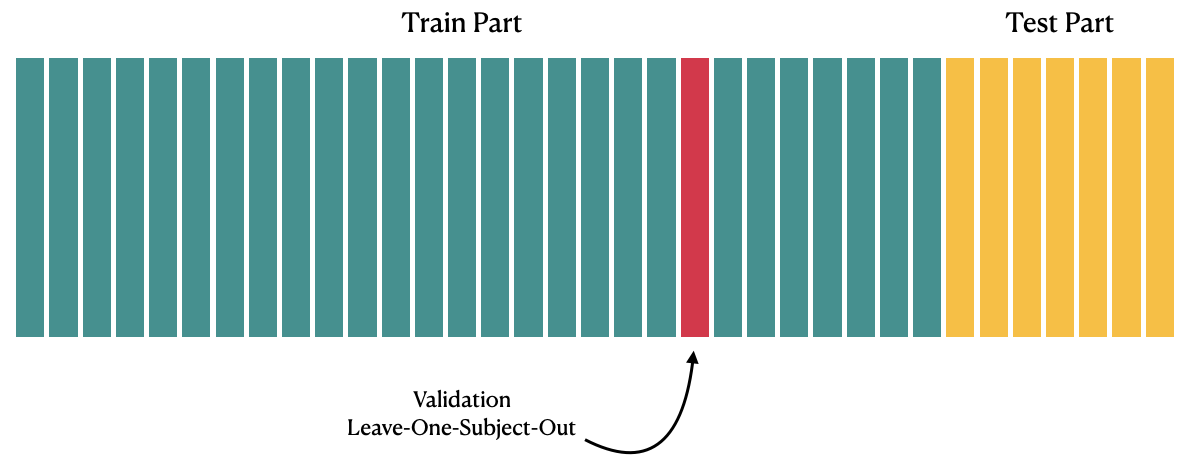

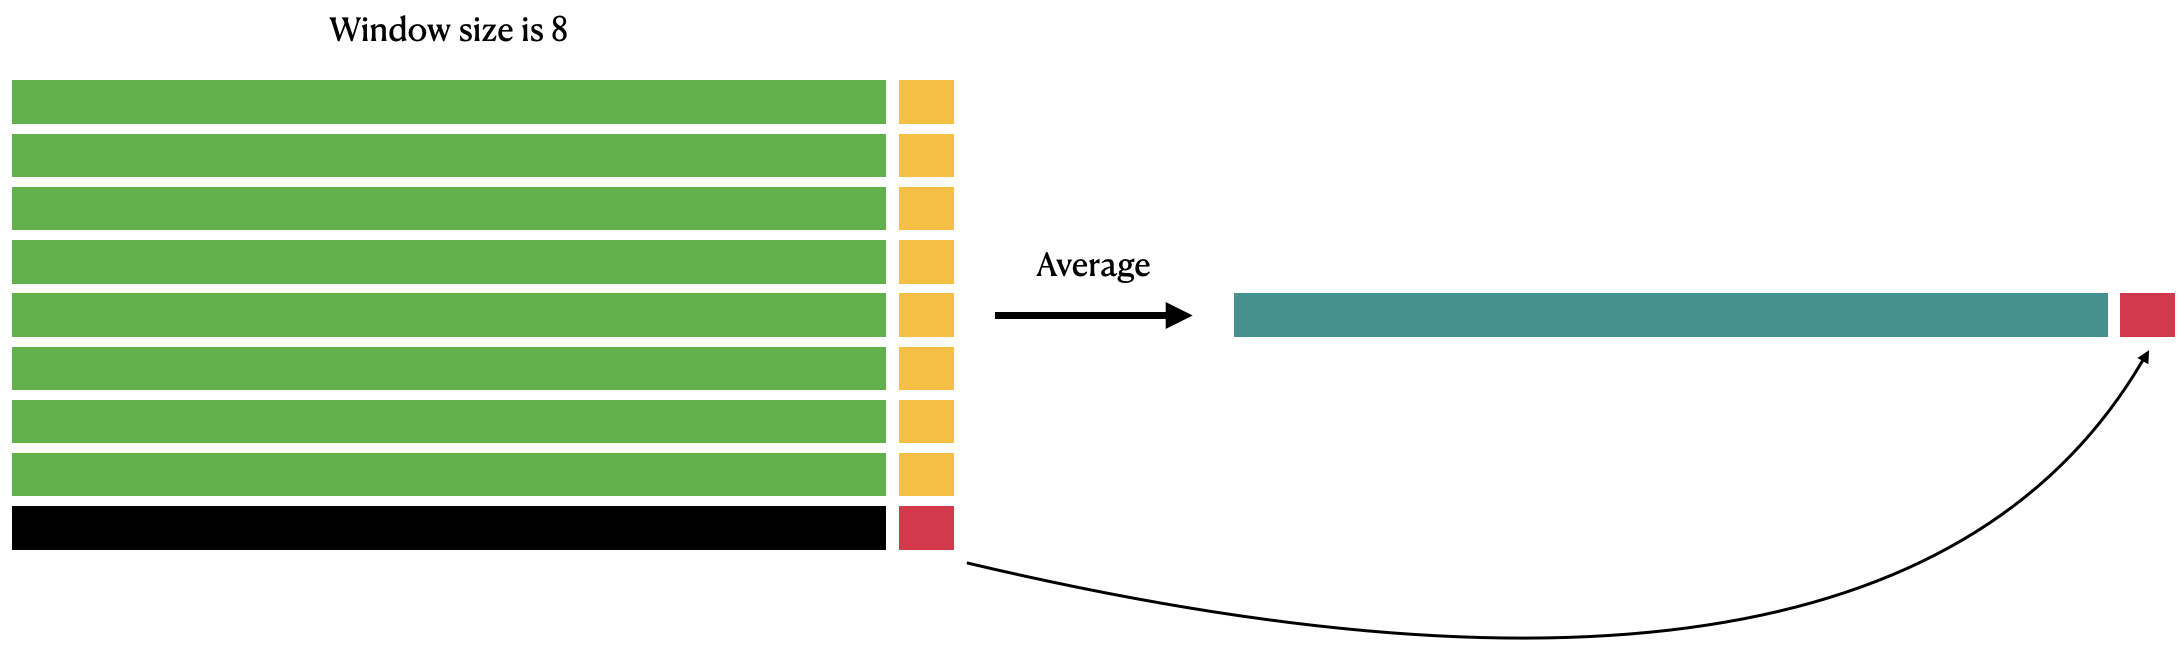

The second image shows how I prepared the time series dataset for a Machine Learning algorithm. I made a window which gets average and the label for the average is the next label.

## Train and Test

participant 1/28    train_accuracy = 76.33    train_F1 = 74.03   val_accuracy = 64.88    val_F1 = 64.16
participant 2/28    train_accuracy = 75.40    train_F1 = 72.21   val_accuracy = 60.98    val_F1 = 56.26
participant 3/28    train_accuracy = 76.36    train_F1 = 74.18   val_accuracy = 70.60    val_F1 = 58.58
participant 4/28    train_accuracy = 74.99    train_F1 = 71.34   val_accuracy = 71.72    val_F1 = 72.82
participant 5/28    train_accuracy = 74.74    train_F1 = 71.14   val_accuracy = 34.38    val_F1 = 23.82
participant 6/28    train_accuracy = 75.76    train_F1 = 74.45   val_accuracy = 63.70    val_F1 = 62.74
participant 7/28    train_accuracy = 74.79    train_F1 = 71.42   val_accuracy = 60.61    val_F1 = 52.87
participant 8/28    train_accuracy = 75.79    train_F1 = 73.19   val_accuracy = 64.88    val_F1 = 53.32
participant 9/28    train_accuracy = 75.74    train_F1 = 72.88   val_accuracy = 27.65    val_F1 = 20.70
participant 10/28    train_accuracy = 76.34    train_F1 = 73.63 

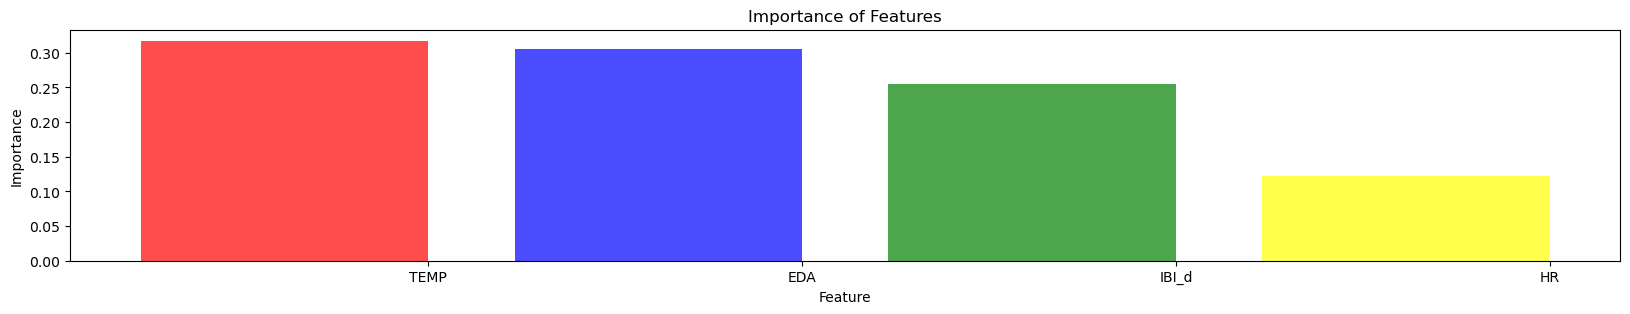

In [5]:
model = Model.Model(model_type="decision_tree", max_depth=7)
model.train(train_data_scaled)
model.test(train_data_scaled, test_data_scaled)
model.important_features(train_data_scaled.drop(columns=['ID', 'Stress']))